# BERT_DGen

## 綁定雲端硬碟

如果用上面的方式下載了CLOTH資料集，這步驟可以跳過

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My Drive/ML

/content/drive/My Drive/ML


In [ ]:
ls -l

total 8
drwx------ 6 root root 4096 Mar 12 13:21 datasets/
drwx------ 7 root root 4096 Mar 12 13:21 models/


## 引用相關套件

In [ ]:
from tqdm.notebook import tqdm
import json
import re
import os

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 資料預處理

### 資料集處理方式

#### 三個錯誤 + SEP + 正確

In [ ]:
import json

with open(r"./datasets/DGen/total_new_cleaned_train.json", "r") as file:
    questions = json.load(file)

print("train:", len(questions))

input_list = list()
label_list = list()

for question in tqdm(questions):
    sent = question["sentence"] + " [SEP] " + question["answer"]
    dis_input = sent.replace("**blank**", "[MASK]")
    diss = question["distractors"]

    for dis in diss:
        dis_label = sent.replace("**blank**", dis)

        input_list.append(dis_input)
        label_list.append(dis_label)

        # print(dis_input)
        # print(dis_label)
        # print("-"*50)

train: 2321


  0%|          | 0/2321 [00:00<?, ?it/s]

### 資料集長度

In [ ]:
print(len(input_list))
print(len(label_list))

7311
7311


In [ ]:
print(input_list[:10])
print(label_list[:10])

['[MASK] causes rocks to roll downhill [SEP] gravity', '[MASK] causes rocks to roll downhill [SEP] gravity', '[MASK] causes rocks to roll downhill [SEP] gravity', "[MASK] of measurement describes an object 's length [SEP] meter", "[MASK] of measurement describes an object 's length [SEP] meter", "[MASK] of measurement describes an object 's length [SEP] meter", "[MASK] is used to determine an object 's texture [SEP] touch", "[MASK] is used to determine an object 's texture [SEP] touch", "[MASK] is used to determine an object 's texture [SEP] touch", '[MASK] is found in food [SEP] chemical']
['friction causes rocks to roll downhill [SEP] gravity', 'erosion causes rocks to roll downhill [SEP] gravity', 'magnetism causes rocks to roll downhill [SEP] gravity', "kilogram of measurement describes an object 's length [SEP] meter", "liter of measurement describes an object 's length [SEP] meter", "degree of measurement describes an object 's length [SEP] meter", "hearing is used to determine a

## BERT fine-tune

使用[bert-base-uncased](https://huggingface.co/bert-base-uncased)預訓練模型，加上英文克漏字資料微調。

In [ ]:
!pip install transformers datasets

In [ ]:
BATCH_SIZE = 64
EPOCH = 1

### 建立Dataset

In [ ]:
data_dic = {"input": input_list, "label": label_list}

In [ ]:
from datasets import Dataset

dataset = Dataset.from_dict(data_dic)

In [ ]:
print(len(dataset))

7311


### 建立DataLoader

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

### 微調模型

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased', return_dict=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


cuda:0


In [ ]:
# 進度條
num_training_steps = EPOCH * len(train_loader)
progress_bar = tqdm(range(num_training_steps))

# 開始訓練
loss_history = []
for epoch in range(EPOCH):
  for batch in train_loader:
    inputs = tokenizer(batch["input"], truncation=True, padding="max_length", max_length=50, return_tensors="pt")
    labels = tokenizer(batch["label"], truncation=True, padding="max_length", max_length=50, return_tensors="pt")["input_ids"]
    # print(inputs)
    # print(labels)
    output = model(**inputs.to(device), labels=labels.to(device))
    optimizer.zero_grad()
    loss = output.loss
    logits = output.logits
    loss_history.append(loss.item())
    loss.backward()
    optimizer.step()
    progress_bar.update(1)
  
  print(f"[epoch {epoch+1}] loss: {loss.item()}")

  0%|          | 0/115 [00:00<?, ?it/s]

[epoch 1] loss: 0.5889828205108643


In [ ]:
print(loss_history)
print(len(loss_history))

[13.703368186950684, 9.048042297363281, 7.8025221824646, 6.538064956665039, 5.356523036956787, 4.956347942352295, 4.46953821182251, 4.083045482635498, 3.260023593902588, 3.1234493255615234, 2.2811591625213623, 2.0023317337036133, 1.9062496423721313, 1.7385090589523315, 1.8333452939987183, 1.476529598236084, 1.0349971055984497, 1.092868447303772, 0.8542084693908691, 1.119100570678711, 1.1708722114562988, 0.9119693636894226, 1.0606558322906494, 0.9824987053871155, 1.1044410467147827, 0.6864480376243591, 0.767777681350708, 0.9277381896972656, 0.912482738494873, 0.9305737018585205, 0.9865925312042236, 0.7818834781646729, 1.0935804843902588, 0.8287262916564941, 0.7022369503974915, 0.710318922996521, 0.7068904638290405, 0.6842042803764343, 0.8043450713157654, 0.7095063924789429, 0.6337127685546875, 0.6674298644065857, 0.7212085127830505, 0.9836699962615967, 0.6005347371101379, 0.5102599859237671, 0.7776198387145996, 0.8705131411552429, 1.0271375179290771, 0.746532142162323, 0.805857300758361

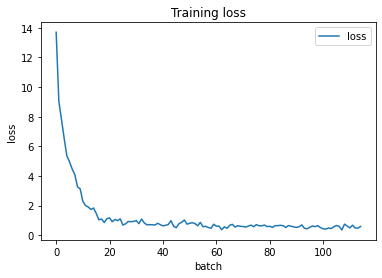

In [ ]:
# paint training loss graph
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.title('Training loss')
plt.ylabel('loss')
plt.xlabel('batch')
plt.legend(['loss'], loc='upper right')
plt.show()

### 模型存檔

In [ ]:
import os

dir_path = r"./models/DGen/"
model_name = "BERT_DGen_model1"

if not os.path.exists(dir_path):
  os.mkdir(dir_path)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(os.path.join(dir_path, model_name))

In [ ]:
del model
torch.cuda.empty_cache()

## 載入模型並初始化

* BERT_DGen_model1: 三個錯誤 + SEP + 正確, batch=64, epoch=1

In [ ]:
# Test data of CLOTH
text1 = "To make Jane live a [MASK] life, Mother was very careful about spending money. [SEP] happy"
# "happy" -> "poor", "busy", "sad"
text2 = "[MASK] , Jane didn't understand her. [SEP] However"
# "However" -> "Though", "Although", "Or"
text3 = "Every day Mother was busy with her [MASK] while Jane was studying at school, so they had little time to enjoy themselves. [SEP] work"
# "work" -> "writing", "housework", "research"
text4 = "One day, Mother realized Jane was unhappy and even [MASK] to her. [SEP] unfriendly"
# "unfriendly" -> "loyal", "kind", "cruel"
text5 = "The wait seemed [MASK] . [SEP] endless"
# "endless" -> "meaningless", "useless", "careless"
text6 = "The old man was waiting for a ride across the [MASK] . [SEP] river"
# "river" -> "town", "country", "island"
text7 = "I felt uncomfortable and out of place as the professor carefully [MASK] what she expected us to learn. [SEP] explained"
# "explained" -> "showed", "designed", "offered"
text8 = "As I listened, I couldn't help but [MASK] of my own oldest daughter. [SEP] think"
# "think" -> "speak", "talk", "hear"
text9 = "As I listened, I couldn't help but think of my own oldest daughter who was now beginning her first year in [MASK], just like me. [SEP] college"
# "college" -> "school", "office", "classroom"

# Sentence on internet
text10 = "Today morning, I saw a [MASK] sitting on the wall. [SEP] cat"
text11 = "Ukrainian presidential adviser says situation is ' [MASK] control' in suburbs and outskirts of Kyiv. [SEP] under"
text12 = "I don't think that after what is [MASK] now, Ukraine has weak positions. [SEP] happening"

# Test data of DGen
text13 = "If an object is attracted to a magnet, the object is most likely made of [MASK]. [SEP] metal"
# "metal" -> "wood", "plastic", "cardboard"
text14 = "the main organs of the respiratory system are [MASK]. [SEP] lungs"
# "lungs" -> "ovaries", "intestines", "kidneys"
text15 = "The products of photosynthesis are glucose and [MASK] else. [SEP] oxygen"
# "oxygen" -> "carbon", "hydrogen", "nitrogen"
text16 = "frogs have [MASK] eyelid membranes. [SEP] three"
# "three" -> "two", "four", "one"
text17 = "the only known planet with large amounts of water is [MASK]. [SEP] earth"
# "earth" -> "saturn", "jupiter", "mars"

In [ ]:
from transformers import BertTokenizer, BertConfig, BertForMaskedLM
import torch
import os

dir_path = r"./models/DGen/BERT_DGen_model1"

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
config = BertConfig.from_pretrained(os.path.join(dir_path, "config.json"))
model = BertForMaskedLM.from_pretrained(os.path.join(dir_path, "pytorch_model.bin"), from_tf=bool('.ckpt' in 'bert-base-uncased'), config=config)
model.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
encoded_input = tokenizer(text1, return_tensors='pt')
output = model(**encoded_input)
print(output)

MaskedLMOutput(loss=None, logits=tensor([[[ -3.6030,  -9.2283,  -9.8280,  ..., -10.3726, -11.2007, -11.1206],
         [ -4.8341,  -9.5772, -10.3804,  ..., -10.9388,  -9.8584, -10.0872],
         [ -6.4476, -10.3895, -10.8414,  ..., -12.0046, -10.2883, -12.1817],
         ...,
         [ -2.4458,  -5.9719,  -5.9276,  ...,  -5.3336,  -4.4885,  -3.3223],
         [ -0.2329,  -6.0625,  -5.9888,  ...,  -7.5686,  -6.1460,  -7.9029],
         [ -2.4491,  -5.9728,  -5.9288,  ...,  -5.3324,  -4.4884,  -3.3217]]],
       grad_fn=<AddBackward0>), hidden_states=None, attentions=None)


### 我的

In [ ]:
from transformers import pipeline
my_unmasker = pipeline('fill-mask', tokenizer=tokenizer, config=config, model=model, top_k=10)

In [ ]:
my_unmasker(text3)

[{'score': 0.10169031471014023,
  'sequence': 'every day mother was busy with her mother while jane was studying at school, so they had little time to enjoy themselves. work',
  'token': 2388,
  'token_str': 'm o t h e r'},
 {'score': 0.08421937376260757,
  'sequence': 'every day mother was busy with her work while jane was studying at school, so they had little time to enjoy themselves. work',
  'token': 2147,
  'token_str': 'w o r k'},
 {'score': 0.054624348878860474,
  'sequence': 'every day mother was busy with her husband while jane was studying at school, so they had little time to enjoy themselves. work',
  'token': 3129,
  'token_str': 'h u s b a n d'},
 {'score': 0.028664326295256615,
  'sequence': 'every day mother was busy with her family while jane was studying at school, so they had little time to enjoy themselves. work',
  'token': 2155,
  'token_str': 'f a m i l y'},
 {'score': 0.020506804808974266,
  'sequence': 'every day mother was busy with her children while jane wa

### 原本的

In [ ]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-base-uncased', top_k=10)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
unmasker(text1)

[{'score': 0.29360201954841614,
  'sequence': 'to make jane live a normal life, mother was very careful about spending money. happy',
  'token': 3671,
  'token_str': 'normal'},
 {'score': 0.14251358807086945,
  'sequence': 'to make jane live a better life, mother was very careful about spending money. happy',
  'token': 2488,
  'token_str': 'better'},
 {'score': 0.1040932908654213,
  'sequence': 'to make jane live a good life, mother was very careful about spending money. happy',
  'token': 2204,
  'token_str': 'good'},
 {'score': 0.09106693416833878,
  'sequence': 'to make jane live a happy life, mother was very careful about spending money. happy',
  'token': 3407,
  'token_str': 'happy'},
 {'score': 0.03141509369015694,
  'sequence': 'to make jane live a simple life, mother was very careful about spending money. happy',
  'token': 3722,
  'token_str': 'simple'},
 {'score': 0.025173284113407135,
  'sequence': 'to make jane live a decent life, mother was very careful about spending mo

In [ ]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-base-cased')

## Test

In [ ]:
!pip install nltk
import nltk
nltk.download("abc")
from nltk.corpus import abc
nltk.download('punkt')

In [ ]:
import random
def random_mask(input_list):
  masked_list = list.copy(input_list)
  masked_list[random.randint(0, len(input_list)-1)]="[MASK]"
  return masked_list

sentens_list = abc.sents()
input_sentences = [ " ".join(sen) for sen in sentens_list]
masked_sentences = [ " ".join(random_mask(sen)) for sen in sentens_list]

In [ ]:
print(input_sentences[:100])

In [ ]:
print(masked_sentences[:100])

## padding before dataset

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

input_encodings = tokenizer(inputs_list, truncation=True, padding="max_length", max_length=30, return_tensors="pt")
label_encodings = tokenizer(labels_list, truncation=True, padding="max_length", max_length=30, return_tensors="pt")

In [ ]:
print(input_encodings["input_ids"].shape)
print(label_encodings["input_ids"].shape)

In [ ]:
input_encodings.keys()

In [ ]:
index = 0

print((tokenizer.convert_ids_to_tokens(input_encodings.input_ids[index])))
print()
print(tokenizer.decode(input_encodings.input_ids[index]))
print()
print(input_encodings.attention_mask[index])

In [ ]:
index = 0

print((tokenizer.convert_ids_to_tokens(label_encodings.input_ids[index])))
print()
print(tokenizer.decode(label_encodings.input_ids[index]))
print()
print(label_encodings.attention_mask[index])

In [ ]:
import torch

class WNDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, index):
        input_ids = torch.tensor(self.encodings["input_ids"][index]).squeeze()
        labels = torch.tensor(self.labels["input_ids"][index]).squeeze()
        
        return {"input_ids": input_ids, "labels": labels}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
train_dataset = WNDataset(input_encodings, label_encodings)

In [ ]:
print(train_dataset[0])

In [ ]:
!nvidia-smi

Sat Feb 19 09:37:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------